In [101]:
import numpy as np
import pandas as pd
from google.colab import drive 
from sklearn.preprocessing import LabelEncoder
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import Lasso
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn import metrics
import os.path

In [67]:
# import full dataset
drive.mount('/content/drive')
dataset = pd.read_csv(("/content/drive/MyDrive/MLOPS/dementia prediction/trainData.csv"))
print("input data shape:",dataset.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
input data shape: (29876, 103)


In [95]:
# extract features and target set from dataset

x = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [103]:
# Correlation Tests
# https://www.kdnuggets.com/2020/08/getting-started-feature-selection.html

lasso = Lasso()
lasso.fit(x, y)
kept_cols = [feature for feature, weight in zip(x.columns.values, lasso.coef_) if weight != 0]
print(kept_cols)
coeffs = pd.DataFrame(np.vstack((x.columns.values,lasso.coef_)).T)
# plot correlation results
fig = go.Figure(
         go.Waterfall(name= "Lasso Coefficients",
                      orientation= "h",
                      y = x.columns.values,
                      x = lasso.coef_))
fig.update_layout(title = "Coefficients of Lasso Regression Model")
fig.show()


coeffs.to_csv(os.path.join('/content/drive/MyDrive/MLOPS/dementia prediction/','lassoCoeffs.csv'))

['Delta Power Fz', 'Delta Power Cz', 'Delta Power Pz', 'Theta Power Fz', 'Theta Power Cz', 'Theta Power Pz', 'Alpha Power Fz', 'Alpha Power Cz', 'Alpha Power Pz', 'Beta Power Fz', 'Beta Power Cz', 'Beta Power Pz', 'Gamma Power Fz', 'Gamma Power Pz', 'Early Delta Power Fz', 'Early Delta Power Cz', 'Early Delta Power Pz', 'Mid Delta Power Fz', 'Mid Delta Power Cz', 'Mid Delta Power Pz', 'Late Delta Power Fz', 'Late Delta Power Cz', 'Late Delta Power Pz', 'Early Theta Power Fz', 'Early Theta Power Cz', 'Early Theta Power Pz', 'Mid Theta Power Fz', 'Mid Theta Power Cz', 'Mid Theta Power Pz', 'Late Theta Power Fz', 'Late Theta Power Cz', 'Late Theta Power Pz', 'Early Alpha Power Fz', 'Early Alpha Power Cz', 'Early Alpha Power Pz', 'Mid Alpha Power Fz', 'Mid Alpha Power Cz', 'Mid Alpha Power Pz', 'Late Alpha Power Fz', 'Late Alpha Power Cz', 'Late Alpha Power Pz', 'Early Beta Power Fz', 'Early Beta Power Cz', 'Early Beta Power Pz', 'Mid Beta Power Fz', 'Mid Beta Power Cz', 'Mid Beta Power Pz

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.438e+05, tolerance: 2.249e+02



In [104]:
xCorr = x[kept_cols]
xCorr = xCorr.to_numpy()
y = y.to_numpy()
y = y.reshape(len(y),1) 

In [105]:
# standardize feature and target set

sslr= StandardScaler() 
xNew = sslr.fit_transform(xCorr) 
y = sslr.fit_transform(y)

In [106]:
x_train, x_test, y_train, y_test= train_test_split(xNew, y, test_size= 0.2, random_state=0) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=0)

Epoch 1/50
561/561 [==============================] - 4s 5ms/step - loss: 0.7684 - mse: 0.7684 - val_loss: 0.4903 - val_mse: 0.4903
Epoch 2/50
561/561 [==============================] - 2s 3ms/step - loss: 0.4728 - mse: 0.4728 - val_loss: 0.3552 - val_mse: 0.3552
Epoch 3/50
561/561 [==============================] - 2s 3ms/step - loss: 0.3363 - mse: 0.3363 - val_loss: 0.2581 - val_mse: 0.2581
Epoch 4/50
561/561 [==============================] - 1s 2ms/step - loss: 0.2257 - mse: 0.2257 - val_loss: 0.3080 - val_mse: 0.3080
Epoch 5/50
561/561 [==============================] - 3s 5ms/step - loss: 0.1773 - mse: 0.1773 - val_loss: 0.0963 - val_mse: 0.0963
Epoch 6/50
561/561 [==============================] - 2s 3ms/step - loss: 0.1005 - mse: 0.1005 - val_loss: 0.1066 - val_mse: 0.1066
Epoch 7/50
561/561 [==============================] - 1s 2ms/step - loss: 0.0576 - mse: 0.0576 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 8/50
561/561 [==============================] - 1s 2ms/step - loss: 0.

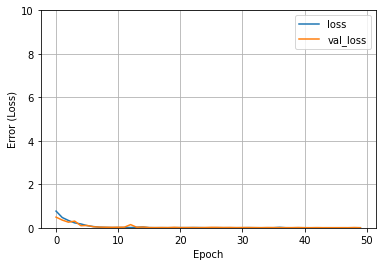

In [107]:
# function with the constructed artifical neural network

def ANN(optimizer = 'adam',neurons_1=32,neurons_2=32,batch_size=32,epochs=50,learning_rate=1e-3):
    model = Sequential()
    model.add(Dense(neurons_1, input_shape=(x_train.shape[1],), activation='relu'))
    model.add(Dense(neurons_2, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',metrics=['mse'])
    history = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val, y_val)) 
    def plot_loss(history):
      plt.plot(history.history['loss'], label='loss')
      plt.plot(history.history['val_loss'], label='val_loss')
      plt.ylim([0,10])
      plt.xlabel('Epoch')
      plt.ylabel('Error (Loss)')
      plt.legend()
      plt.grid(True)
    ########################################################
    plot_loss(history)
    return model

clf =ANN()

In [ ]:
rf_params = {
    'optimizer': ['adam','rmsprop'], 
    'neurons_1': list(np.arange(16,96,16)),
    'neurons_2': list(np.arange(16,96,16)),
    'batch_size': [16,32,64],
    'epochs':[10,20,30,40,50],
    'learning_rate': [1e-1,1e-2,1e-3,1e-4]
}
n_iter_search=10
clf = KerasRegressor(build_fn=ANN, verbose=0)
random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='neg_mean_squared_error')
random.fit(x_train, y_train)
print(random.best_params_)
randomParams = random.best_params_
print("MSE:"+ str(-random.best_score_))

In [ ]:
# save the model with the best parameters

In [ ]:
# test the new model on the test set